# 3. Model with biased features to predict Mortality

In this final notebook, we will create a  machine learning (ML) to predict in-hospital mortality, but now using the modified features, i.e, exaggerating the biases that we may see in real-world data. Copy any code that you may need from the previous notebooks. Please select the features according to the track that has been assigned to your team! In the end, please compare the results, and prepare your presentation!

## Import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [24]:
# some possibilities for modelling and evaluation, uncomment if necessary!

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import shap


In [25]:
# import XGBoost, as an examplar, if this is the model you go for

# try:
#     from xgboost import XGBClassifier
# except (ModuleNotFoundError, ImportError):
#     # install if necessary
#     !pip install xgboost
#     from xgboost import XGBClassifier

## Load train and test data

In [26]:
# Load the training and test data
train_data = pd.read_csv('data_split/wids_train.csv')
test_data = pd.read_csv('data_split/wids_test.csv')

### Separate features and target variable

In [27]:
X = train_data.drop(columns=['hospital_death'])
y = train_data['hospital_death']

X_test = test_data.drop(columns=['hospital_death'])
y_test = test_data['hospital_death']

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73370 entries, 0 to 73369
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          73370 non-null  int64  
 1   encounter_id        73370 non-null  int64  
 2   patient_id          73370 non-null  int64  
 3   hospital_id         73370 non-null  int64  
 4   age                 69983 non-null  float64
 5   ethnicity           72264 non-null  object 
 6   gender              73353 non-null  object 
 7   bmi                 70604 non-null  float64
 8   icu_admit_source    73282 non-null  object 
 9   icu_type            73370 non-null  object 
 10  d1_heartrate_max    73254 non-null  float64
 11  d1_heartrate_min    73254 non-null  float64
 12  d1_mbp_max          73189 non-null  float64
 13  d1_mbp_min          73189 non-null  float64
 14  d1_sysbp_max        73237 non-null  float64
 15  d1_sysbp_min        73237 non-null  float64
 16  d1_d

In [29]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 73370 entries, 0 to 73369
Series name: hospital_death
Non-Null Count  Dtype
--------------  -----
73370 non-null  int64
dtypes: int64(1)
memory usage: 573.3 KB


In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18343 entries, 0 to 18342
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          18343 non-null  int64  
 1   encounter_id        18343 non-null  int64  
 2   patient_id          18343 non-null  int64  
 3   hospital_id         18343 non-null  int64  
 4   age                 17502 non-null  float64
 5   ethnicity           18054 non-null  object 
 6   gender              18335 non-null  object 
 7   bmi                 17680 non-null  float64
 8   icu_admit_source    18319 non-null  object 
 9   icu_type            18343 non-null  object 
 10  d1_heartrate_max    18314 non-null  float64
 11  d1_heartrate_min    18314 non-null  float64
 12  d1_mbp_max          18304 non-null  float64
 13  d1_mbp_min          18304 non-null  float64
 14  d1_sysbp_max        18317 non-null  float64
 15  d1_sysbp_min        18317 non-null  float64
 16  d1_d

In [31]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18343 entries, 0 to 18342
Series name: hospital_death
Non-Null Count  Dtype
--------------  -----
18343 non-null  int64
dtypes: int64(1)
memory usage: 143.4 KB


## Select which features to use

Please comment the cells that do not apply to your track, and run the one that does apply

***To make this model's results comparable with the one from the previous notebook, please make sure to keep the same features, except for the SpO2 and/or Lactate***

### if you are Track 1 (modified SpO2 only)

We are selecting the minimum SpO2 because it is most representative of a patient's illness severity

In [32]:
features = [
    'd1_spo2_min_new',
    'd1_lactate_max', #original
    'bmi',
    'age',
    'ethnicity',
    'gender',
    # same features as before
]

In [33]:
X = X[features]
X_test = X_test[features]

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73370 entries, 0 to 73369
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   d1_spo2_min_new  73099 non-null  float64
 1   d1_lactate_max   18643 non-null  float64
 2   bmi              70604 non-null  float64
 3   age              69983 non-null  float64
 4   ethnicity        72264 non-null  object 
 5   gender           73353 non-null  object 
dtypes: float64(4), object(2)
memory usage: 3.4+ MB


In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18343 entries, 0 to 18342
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   d1_spo2_min_new  18281 non-null  float64
 1   d1_lactate_max   4674 non-null   float64
 2   bmi              17680 non-null  float64
 3   age              17502 non-null  float64
 4   ethnicity        18054 non-null  object 
 5   gender           18335 non-null  object 
dtypes: float64(4), object(2)
memory usage: 860.0+ KB


In [36]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 73370 entries, 0 to 73369
Series name: hospital_death
Non-Null Count  Dtype
--------------  -----
73370 non-null  int64
dtypes: int64(1)
memory usage: 573.3 KB


In [37]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18343 entries, 0 to 18342
Series name: hospital_death
Non-Null Count  Dtype
--------------  -----
18343 non-null  int64
dtypes: int64(1)
memory usage: 143.4 KB


# Data preparation

In [38]:
# Handle missing values
X_not_nan = X.dropna()
y_not_nan = y.loc[X_not_nan.index]

In [39]:
X_not_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17145 entries, 1 to 73362
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   d1_spo2_min_new  17145 non-null  float64
 1   d1_lactate_max   17145 non-null  float64
 2   bmi              17145 non-null  float64
 3   age              17145 non-null  float64
 4   ethnicity        17145 non-null  object 
 5   gender           17145 non-null  object 
dtypes: float64(4), object(2)
memory usage: 937.6+ KB


In [40]:
y_not_nan.info()

<class 'pandas.core.series.Series'>
Index: 17145 entries, 1 to 73362
Series name: hospital_death
Non-Null Count  Dtype
--------------  -----
17145 non-null  int64
dtypes: int64(1)
memory usage: 267.9 KB


In [41]:
# Separate numerical and categorical variables
numeric_features = X_not_nan.select_dtypes(include=[np.number]).columns
categorical_features = X_not_nan.select_dtypes(include=[object]).columns

X_numeric = X_not_nan[numeric_features]
X_categorical = X_not_nan[categorical_features]

# Binning the 'age' variable into ranges
age_bins = [0, 18, 30, 45, 60, 80, np.inf]
age_labels = ['0-18', '19-30', '31-45', '46-60', '61-80', '80+']
X_numeric['age'] = pd.cut(X_numeric['age'], bins=age_bins, labels=age_labels)

# Encode categorical variables
label_encoders = {}
for column in X_categorical.columns:
    le = LabelEncoder()
    X_categorical[column] = le.fit_transform(X_categorical[column].astype(str))
    label_encoders[column] = le

# Encode the binned 'age' variable
age_encoder = LabelEncoder()
X_numeric['age'] = age_encoder.fit_transform(X_numeric['age'].astype(str))
label_encoders['age'] = age_encoder

# Combine numerical and categorical variables before scaling
X_combined = pd.concat([X_numeric, X_categorical], axis=1)

# Standardize numerical variables (excluding binned 'age')
scaler = StandardScaler()
numeric_features_to_scale = X_numeric.columns.difference(['age'])
X_combined[numeric_features_to_scale] = scaler.fit_transform(X_combined[numeric_features_to_scale])

# Rebalance the dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_combined, y_not_nan)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [42]:
print(X_train.head())

       d1_spo2_min_new  d1_lactate_max       bmi  age  ethnicity  gender
52100         0.233638       -0.821723  0.480922    3          2       1
27124        -0.997528        0.126349  1.703046    3          0       0
26972         0.233638        0.527963  0.247945    4          2       0
14585         0.233638       -0.393774 -1.125517    5          2       0
51821         0.069482       -0.038247  0.319227    5          2       1


In [43]:
print(X_val.head())

       d1_spo2_min_new  d1_lactate_max       bmi  age  ethnicity  gender
60864         0.397793       -0.492531  0.914949    3          2       0
44149        -0.258829       -0.262097 -0.134198    4          2       1
37775         0.151560       -0.360854 -0.499788    5          2       1
18630        -4.773105        3.161497 -1.661243    4          2       0
9402         -0.012595       -0.130420  0.845085    4          2       1


Columns in X_train_mapped before plotting: Index(['d1_spo2_min_new', 'd1_lactate_max', 'bmi', 'age', 'ethnicity',
       'gender'],
      dtype='object')


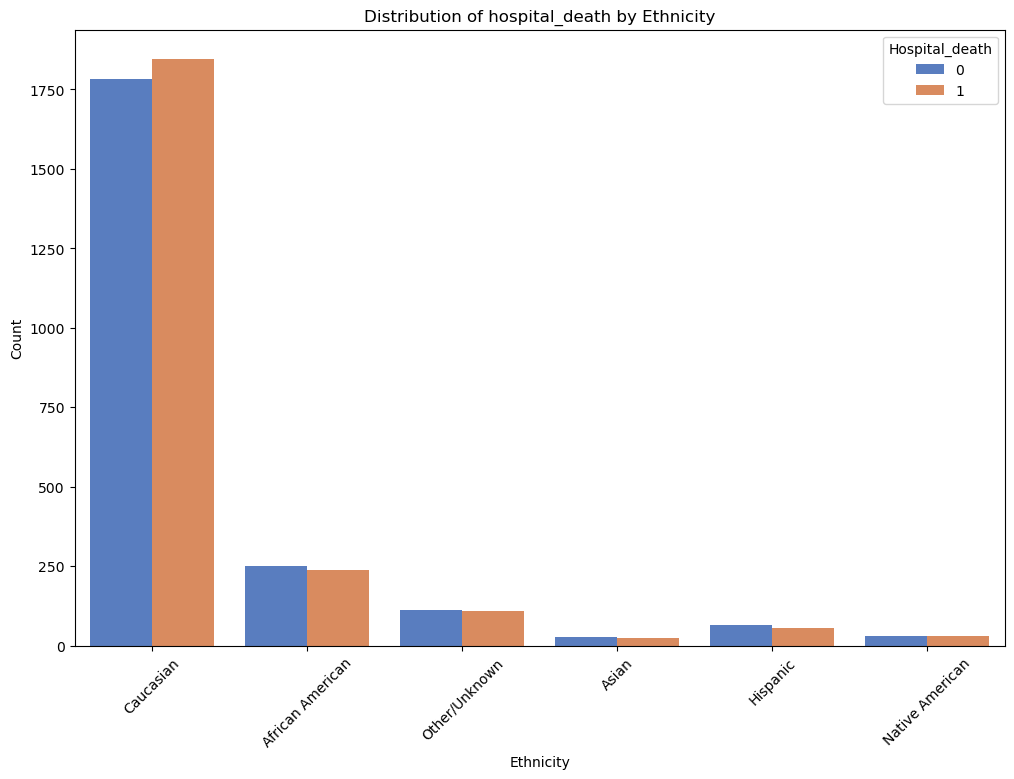

Unique values in 'ethnicity' after mapping: ['Caucasian' 'African American' 'Other/Unknown' 'Asian' 'Hispanic'
 'Native American']


In [44]:
ethnicity_mapping = {index: label for index, label in enumerate(label_encoders['ethnicity'].classes_)}

# Function to map encoded values to original labels
def map_encoded_labels(data, column, mapping):
    data[column] = data[column].map(mapping)
    return data

# Create a copy of X_train to avoid modifying the original dataframe
X_train_mapped = X_train.copy()
X_train_mapped = map_encoded_labels(X_train_mapped, 'ethnicity', ethnicity_mapping)

# Function to create the plot for categorical variables with original labels
def plot_categorical_distribution(data, column, hue, palette='muted'):
    plt.figure(figsize=(12, 8))
    sns.countplot(x=column, hue=hue, data=data, palette=palette)
    plt.title(f'Distribution of {hue.name} by {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=hue.name.capitalize())
    plt.show()

# Check the columns in X_train_mapped
print("Columns in X_train_mapped before plotting:", X_train_mapped.columns)

# Create the plot for 'ethnicity' with original labels
plot_categorical_distribution(X_train_mapped, 'ethnicity', y_train)

# Check unique values in 'ethnicity' to verify they are mapped correctly
print("Unique values in 'ethnicity' after mapping:", X_train_mapped['ethnicity'].unique())

In [45]:
# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Evaluate performance on Validation set

In [46]:
# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluate the model
print("Overall Metrics:")
print("Accuracy: ", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_val, y_pred_proba))


Overall Metrics:
Accuracy:  0.6949300699300699
Confusion Matrix:
 [[465 121]
 [228 330]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.79      0.73       586
           1       0.73      0.59      0.65       558

    accuracy                           0.69      1144
   macro avg       0.70      0.69      0.69      1144
weighted avg       0.70      0.69      0.69      1144

ROC AUC Score:  0.7753342630310593


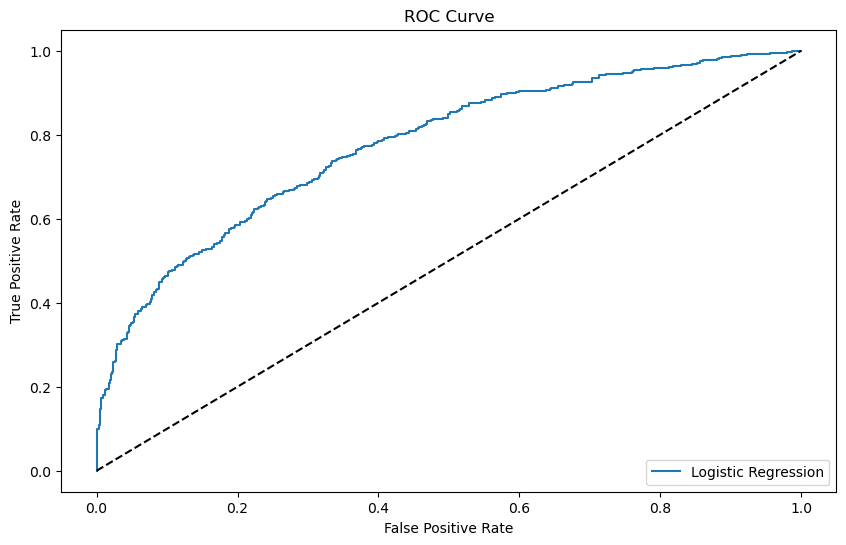

In [47]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Explainable AI

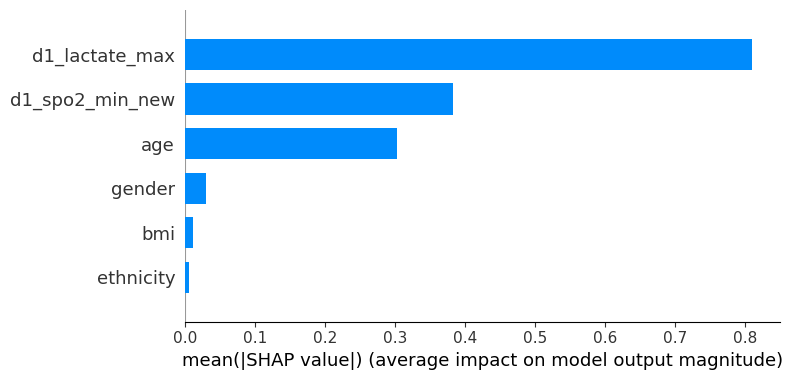

In [48]:
# Explainability using SHAP
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="correlation_dependent")
shap_values = explainer.shap_values(X_val)

# Summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [49]:
# Create a copy of X_val to avoid modifying the original dataframe
X_val_mapped = X_val.copy()
X_val_mapped = map_encoded_labels(X_val_mapped, 'ethnicity', ethnicity_mapping)

# Evaluate the model for each racial and ethnic group
ethnic_groups = X_val_mapped['ethnicity'].unique()
accuracy_scores = []
roc_auc_scores = []

for group in ethnic_groups:
    group_indices = X_val_mapped['ethnicity'] == group
    X_group = X_val_mapped[group_indices]
    y_group_true = y_val[group_indices]
    y_group_pred = y_pred[group_indices]
    y_group_pred_proba = y_pred_proba[group_indices]
    acc = accuracy_score(y_group_true, y_group_pred)
    roc_auc = roc_auc_score(y_group_true, y_group_pred_proba)
    accuracy_scores.append(acc)
    roc_auc_scores.append(roc_auc)
    print(f"\nMetrics for Ethnic Group: {group}")
    print("Accuracy: ", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_group_true, y_group_pred))
    print("Classification Report:\n", classification_report(y_group_true, y_group_pred))
    print("ROC AUC Score: ", roc_auc)



Metrics for Ethnic Group: Caucasian
Accuracy:  0.6915584415584416
Confusion Matrix:
 [[356 103]
 [182 283]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71       459
           1       0.73      0.61      0.67       465

    accuracy                           0.69       924
   macro avg       0.70      0.69      0.69       924
weighted avg       0.70      0.69      0.69       924

ROC AUC Score:  0.7715370018975332

Metrics for Ethnic Group: African American
Accuracy:  0.7350427350427351
Confusion Matrix:
 [[55  7]
 [24 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.89      0.78        62
           1       0.82      0.56      0.67        55

    accuracy                           0.74       117
   macro avg       0.76      0.73      0.72       117
weighted avg       0.75      0.74      0.73       117

ROC AUC Score:  0.8073313782991203

Metric

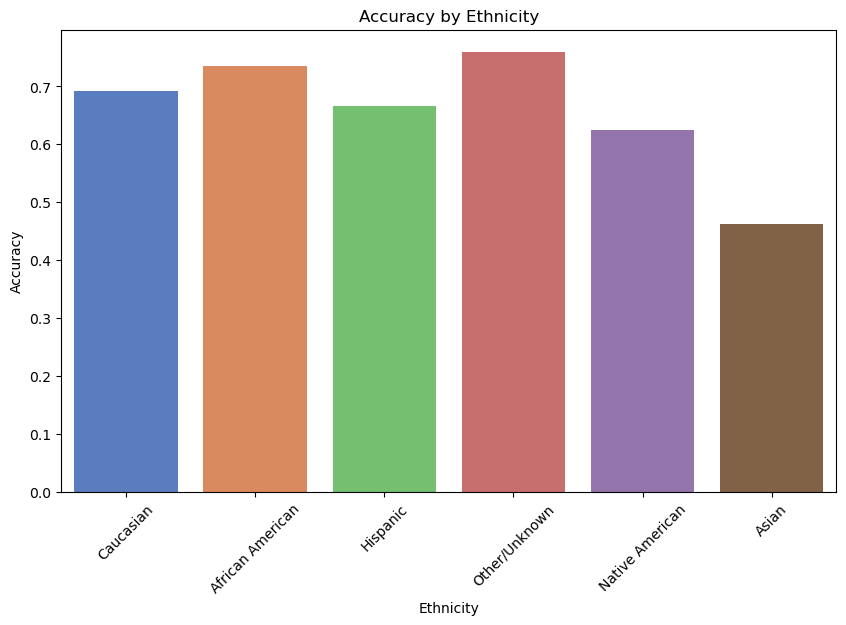

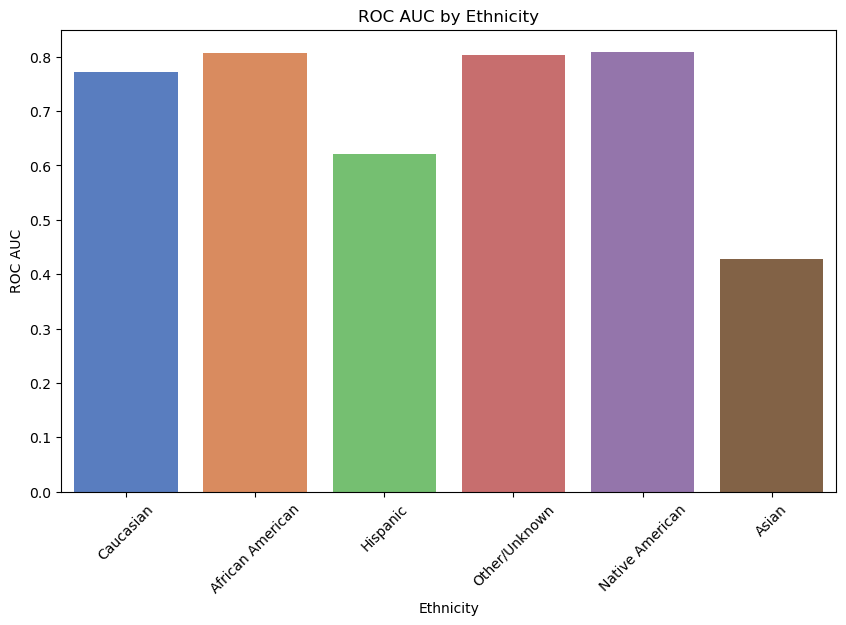

In [50]:
# Bar plot for accuracy by ethnicity
plt.figure(figsize=(10, 6))
sns.barplot(x=ethnic_groups, y=accuracy_scores, palette='muted')
plt.title('Accuracy by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Bar plot for ROC AUC by ethnicity
plt.figure(figsize=(10, 6))
sns.barplot(x=ethnic_groups, y=roc_auc_scores, palette='muted')
plt.title('ROC AUC by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('ROC AUC')
plt.xticks(rotation=45)
plt.show()

# Evaluete the performance of the model on test set

In [51]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18343 entries, 0 to 18342
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   d1_spo2_min_new  18281 non-null  float64
 1   d1_lactate_max   4674 non-null   float64
 2   bmi              17680 non-null  float64
 3   age              17502 non-null  float64
 4   ethnicity        18054 non-null  object 
 5   gender           18335 non-null  object 
dtypes: float64(4), object(2)
memory usage: 860.0+ KB


In [52]:
# Remove rows with missing values in test set
X_test_res = X_test.dropna()
y_test_res = y_test.loc[X_test_res.index]

In [53]:
X_test_res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4249 entries, 6 to 18339
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   d1_spo2_min_new  4249 non-null   float64
 1   d1_lactate_max   4249 non-null   float64
 2   bmi              4249 non-null   float64
 3   age              4249 non-null   float64
 4   ethnicity        4249 non-null   object 
 5   gender           4249 non-null   object 
dtypes: float64(4), object(2)
memory usage: 232.4+ KB


In [54]:
X_test_res.head()

,d1_spo2_min_new,d1_lactate_max,bmi,age,ethnicity,gender
6,90.0,2.6,38.173554,74.0,Caucasian,M
10,87.0,0.7,52.498330,59.0,Caucasian,F
11,96.0,1.9,27.649123,82.0,Caucasian,M
19,90.0,2.4,27.996375,55.0,Caucasian,M
20,100.0,1.5,42.380529,58.0,African American,M


In [55]:
y_test_res.info()

<class 'pandas.core.series.Series'>
Index: 4249 entries, 6 to 18339
Series name: hospital_death
Non-Null Count  Dtype
--------------  -----
4249 non-null   int64
dtypes: int64(1)
memory usage: 66.4 KB


In [56]:
# Apply the same binning to the 'age' variable in the test set
X_test_res['age'] = pd.cut(X_test_res['age'], bins=age_bins, labels=age_labels)

# Encode categorical variables in the test set using the fitted label encoders
for column in X_test_res.select_dtypes(include=[object]).columns:
    if column in label_encoders:  # Ensure the column was encoded in the training phase
        le = label_encoders[column]
        X_test_res[column] = le.transform(X_test_res[column].astype(str))

# Encode the binned 'age' variable in the test set
X_test_res['age'] = age_encoder.transform(X_test_res['age'].astype(str))

In [57]:
# Identify the numeric features to scale (excluding age)
numeric_features_to_scale = X_test_res.select_dtypes(include=[np.number]).columns.difference(['age', 'gender', 'ethnicity'])

# Apply StandardScaler to the numeric features in the test set using the fitted scaler
X_test_res[numeric_features_to_scale] = scaler.transform(X_test_res[numeric_features_to_scale])

In [58]:
X_test_res.head()

,d1_spo2_min_new,d1_lactate_max,bmi,age,ethnicity,gender
6,0.069482,-0.097501,0.996530,4,2,1
10,-0.176751,-0.722965,2.628516,3,2,0
11,0.561949,-0.327935,-0.202492,5,2,1
19,0.069482,-0.163339,-0.162931,3,2,1
20,0.890260,-0.459612,1.475820,3,0,1


In [59]:
# Create a mapping dictionary for ethnicity
ethnicity_mapping = {index: label for index, label in enumerate(label_encoders['ethnicity'].classes_)}

# Function to map encoded values to original labels
def map_encoded_labels(data, column, mapping):
    data[column] = data[column].map(mapping)
    return data

# Create a copy of X_test_res to avoid modifying the original dataframe
X_test_mapped = X_test_res.copy()
X_test_mapped = map_encoded_labels(X_test_mapped, 'ethnicity', ethnicity_mapping)

# Evaluate the model for each racial and ethnic group in the test set
ethnic_groups = X_test_mapped['ethnicity'].unique()
accuracy_scores = []
roc_auc_scores = []


# Compute predictions on test set
y_pred_test = model.predict(X_test_res)
y_pred_proba_test = model.predict_proba(X_test_res)[:, 1]

for group in ethnic_groups:
    group_indices = X_test_mapped['ethnicity'] == group
    X_group = X_test_mapped[group_indices]
    y_group_true = y_test_res[group_indices]
    y_group_pred = y_pred_test[group_indices]
    y_group_pred_proba = y_pred_proba_test[group_indices]
    acc = accuracy_score(y_group_true, y_group_pred)
    roc_auc = roc_auc_score(y_group_true, y_group_pred_proba)
    accuracy_scores.append(acc)
    roc_auc_scores.append(roc_auc)
    print(f"\nMetrics for Ethnic Group: {group}")
    print("Accuracy: ", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_group_true, y_group_pred))
    print("Classification Report:\n", classification_report(y_group_true, y_group_pred))
    print("ROC AUC Score: ", roc_auc)

# Print overall metrics
print("\nOverall Metrics on Test Set:")
print("Average Accuracy: ", sum(accuracy_scores) / len(accuracy_scores))
print("Average ROC AUC Score: ", sum(roc_auc_scores) / len(roc_auc_scores))


Metrics for Ethnic Group: Caucasian
Accuracy:  0.7564720048163757
Confusion Matrix:
 [[2166  602]
 [ 207  347]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84      2768
           1       0.37      0.63      0.46       554

    accuracy                           0.76      3322
   macro avg       0.64      0.70      0.65      3322
weighted avg       0.82      0.76      0.78      3322

ROC AUC Score:  0.7774918616055592

Metrics for Ethnic Group: African American
Accuracy:  0.8020618556701031
Confusion Matrix:
 [[345  63]
 [ 33  44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       408
           1       0.41      0.57      0.48        77

    accuracy                           0.80       485
   macro avg       0.66      0.71      0.68       485
weighted avg       0.83      0.80      0.81       485

ROC AUC Score:  0.7661064425770308